<a href="https://colab.research.google.com/github/sergienko4/deep-learing/blob/main/ex10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning: Ex.10 - RNN

Submitted by: [... **your name and ID** ...]


In [157]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input
from tensorflow.keras.layers import SimpleRNN, LSTM # <--- recurrent layers

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from seaborn import heatmap
import re
print(tf.__version__)

2.7.0


In [158]:
from google.colab import drive
drive.mount('/content/drive')
path='/content/drive/MyDrive/ex10/war_and_peace.txt'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


***
### 1. Preprocess the text corpus

(if you are using google colab, remember to upload the corpus file first..)

In [159]:
# f = open('war_and_peace.txt','r') # open the corpus file
f = open(path,'r') 
text = f.read().lower()  # read file and convert to lower-case letters
data = text.replace('\n',' ')

data = re.sub(r'[^a-zA-Z0-9 ]',r'',data)

print('len(text) = ',len(text))

print(data[:400]) # print the first 400 characters..

len(text) =  3196213
well prince so genoa and lucca are now just family estates of the buonapartes but i warn you if you dont tell me that this means war if you still try to defend the infamies and horrors perpetrated by that antichristi really believe he is antichristi will have nothing more to do with you and you are no longer my friend no longer my faithful slave as you call yourself but how do you do i see i have 


- generate training sequences of `T=20` characters, by sampling the text corpus with a stride of 5 characters (i.e., each sequences starts 5 chars after the begining of the last sequences).

- generate a matching list, holding the `next_char` for each of your sequences.

- how many sequences did you extract in total? `N = ?`

- convert the sequences into a 1-hot representation, suitable for our model trainig:

`X.shape = (N, T, len(chars))`

`Y.shape = (N, len(chars))`

In [160]:
chars = sorted(list(set(data)))
data_size, vocab_size = len(data), len(chars)
print('There are %d total characters and %d unique characters in your data.' % (data_size, vocab_size))
print('chars = ',chars)

There are 3083435 total characters and 37 unique characters in your data.
chars =  [' ', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [161]:
char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }

# ix_to_char

In [162]:
T = 20  # extract training sequences of length T
stride = 5

sequences = []  # This holds our extracted sequences
next_chars = []  # This holds the targets (the follow-up character)

for i in range(0, len(data) - T, stride):
    sequences.append(data[i: i + T])
    next_chars.append(data[i + T])

In [163]:
X = np.zeros((len(sequences), T, len(chars)), dtype='bool')
Y = np.zeros((len(sequences), len(chars)), dtype='bool')

for i, seq in enumerate(sequences):
    for t, char in enumerate(seq):
        X[i, t, char_to_ix[char]] = 1
    Y[i, char_to_ix[next_chars[i]]] = 1
    
print('X.shape = (#examples, T, input-dim) =', X.shape)
print('Y.shape = (#examples, output-dim) =', Y.shape)

X.shape = (#examples, T, input-dim) = (616683, 20, 37)
Y.shape = (#examples, output-dim) = (616683, 37)


***
### 2. LTSM Model

- Build an `LTSM` model with 128 (hidden)-units that accepts the input sequences. Add a `Dense` layer on top of it, with `len(chars)` softmax units.

- Train the model for only 1 epoch (use: `RMSprop` and batch size of 128).



In [164]:
model = Sequential(name='LSTM_128')
model.add(Input(shape=(T, len(chars))))  # (12,27)
model.add(LSTM(128)) # 128 internal state units
model.add(Dense(len(chars), activation="softmax"))
model.summary()

Model: "LSTM_128"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_45 (LSTM)              (None, 128)               84992     
                                                                 
 dense_29 (Dense)            (None, 37)                4773      
                                                                 
Total params: 89,765
Trainable params: 89,765
Non-trainable params: 0
_________________________________________________________________


In [165]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

history = model.fit(X, Y, epochs=1, batch_size=128)

4818/4818 [==============================] - 19s 4ms/step - loss: 2.0271


### 3. Model predictions


- use the senternce `the meaning of life ` as an input to the model (convert it to 1-hot first..),

- plot the model's output as a probability distribution over the list of chars.

- sample a single char from that distribution, and add it to the generated sentence.

- update the 1-hot buffer, and continue the process for 99 more letters (using a loop).

- print the resulting sentence.

In [166]:
input = 'the meaning of life'

In [167]:
input_one_hot = np.zeros((len(input), T, len(chars)), dtype='bool')

In [168]:
input_one_hot.shape

(19, 20, 37)

In [169]:
y_hat = model.predict(input_one_hot)

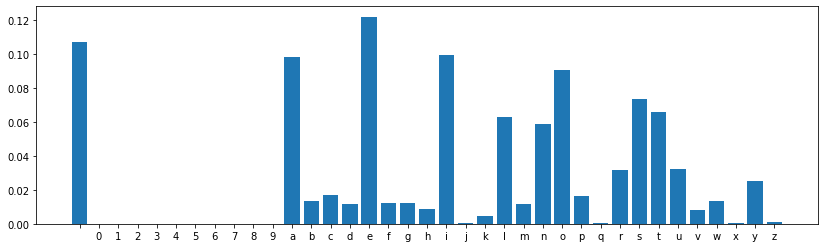

In [170]:
plt.figure(figsize=(14,4))
plt.bar(range(len(chars)), y_hat[0])
plt.xticks(range(len(chars)), labels=chars)
plt.show()

In [171]:
input_buffer = input_one_hot[0]
generated_text = input

yy = []
for i in range(100):
    yhat = model.predict(input_buffer[None,:])
    # sample the next character:
    # ix = np.argmax(yhat)
    ix = np.random.choice(range(len(chars)), p=yhat[0])
    ch = ix_to_char[ix]
    generated_text += ch
    # update the input buffer:
    input_buffer = np.r_[input_buffer[1:,:], np.zeros((1,len(chars)))]
    input_buffer[-1,ix] = 1
    yy.append(yhat)
print(generated_text)

the meaning of lifeing ttrumsice befy becheed in pebiril lepreshe ang alluthousale to geerams but what mole thes wald b


***
### 3. Fit your model

- Fit your model a bit more (try 10-20 epochs), and regenerate a new `N=100` sentence sample. Does it get any better?

- If you wish, you can try to train the model further, or you can try using a different corpus (dataset) for the training (you can even try a text in hebrew). Be creative ;)

In [172]:
history = model.fit(X, Y, epochs=20, batch_size=128)

Epoch 1/20
1205/1205 [==============================] - 6s 5ms/step - loss: 1.6829
Epoch 2/20
1205/1205 [==============================] - 6s 5ms/step - loss: 1.5883
Epoch 3/20
1205/1205 [==============================] - 6s 5ms/step - loss: 1.5251
Epoch 4/20
1205/1205 [==============================] - 6s 5ms/step - loss: 1.4788
Epoch 5/20
1205/1205 [==============================] - 6s 5ms/step - loss: 1.4434
Epoch 6/20
1205/1205 [==============================] - 6s 5ms/step - loss: 1.4150
Epoch 7/20
1205/1205 [==============================] - 6s 5ms/step - loss: 1.3914
Epoch 8/20
1205/1205 [==============================] - 6s 5ms/step - loss: 1.3714
Epoch 9/20
1205/1205 [==============================] - 6s 5ms/step - loss: 1.3546
Epoch 10/20
1205/1205 [==============================] - 6s 5ms/step - loss: 1.3394
Epoch 11/20
1205/1205 [==============================] - 6s 5ms/step - loss: 1.3261
Epoch 12/20
1205/1205 [==============================] - 6s 5ms/step - loss: 1.3142
E

In [173]:
input_buffer = input_one_hot[0]
generated_text = input

yy = []
for i in range(100):
    yhat = model.predict(input_buffer[None,:])
    # sample the next character:
    # ix = np.argmax(yhat)
    ix = np.random.choice(range(len(chars)), p=yhat[0])
    ch = ix_to_char[ix]
    generated_text += ch
    # update the input buffer:
    input_buffer = np.r_[input_buffer[1:,:], np.zeros((1,len(chars)))]
    input_buffer[-1,ix] = 1
    yy.append(yhat)
print(generated_text)

the meaning of lifeended those whole the curters due of burden this on the evident into the bood in the backs of that o


In [174]:
X.shape

(616683, 20, 37)

In [175]:
#---------------------------------------------------freestyle---------------------------------------------------

In [176]:
model_freestyle = Sequential(name='freestyle')
model_freestyle.add(LSTM(
        256,
        input_shape=(X.shape[1], X.shape[2]),
        return_sequences=True
    ))
model_freestyle.add(Dropout(0.3))
model_freestyle.add(LSTM(512, return_sequences=True))
model_freestyle.add(Dropout(0.3))
model_freestyle.add(LSTM(256))
model_freestyle.add(Dense(256))
model_freestyle.add(Dropout(0.3))
model_freestyle.add(Dense(vocab_size))
model_freestyle.add(Activation('softmax'))
model_freestyle.compile(loss='categorical_crossentropy', optimizer='rmsprop')
model_freestyle.summary()


Model: "freestyle"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_46 (LSTM)              (None, 20, 256)           301056    
                                                                 
 dropout_31 (Dropout)        (None, 20, 256)           0         
                                                                 
 lstm_47 (LSTM)              (None, 20, 512)           1574912   
                                                                 
 dropout_32 (Dropout)        (None, 20, 512)           0         
                                                                 
 lstm_48 (LSTM)              (None, 256)               787456    
                                                                 
 dense_30 (Dense)            (None, 256)               65792     
                                                                 
 dropout_33 (Dropout)        (None, 256)               0 

In [177]:
history = model_freestyle.fit(X, Y, epochs=100, batch_size=1024)

Epoch 1/100
603/603 [==============================] - 42s 64ms/step - loss: 2.3344
Epoch 2/100
603/603 [==============================] - 38s 64ms/step - loss: 1.7112
Epoch 3/100
603/603 [==============================] - 38s 64ms/step - loss: 1.4780
Epoch 4/100
603/603 [==============================] - 38s 64ms/step - loss: 1.3679
Epoch 5/100
603/603 [==============================] - 38s 64ms/step - loss: 1.3024
Epoch 6/100
603/603 [==============================] - 38s 64ms/step - loss: 1.2552
Epoch 7/100
603/603 [==============================] - 38s 64ms/step - loss: 1.2184
Epoch 8/100
603/603 [==============================] - 39s 64ms/step - loss: 1.1879
Epoch 9/100
603/603 [==============================] - 38s 64ms/step - loss: 1.1624
Epoch 10/100
603/603 [==============================] - 38s 64ms/step - loss: 1.1384
Epoch 11/100
603/603 [==============================] - 39s 64ms/step - loss: 1.1166
Epoch 12/100
603/603 [==============================] - 38s 64ms/step - lo

In [178]:
input_buffer = input_one_hot[0]
generated_text = input

yy = []
for i in range(100):
    yhat = model.predict(input_buffer[None,:])
    # sample the next character:
    # ix = np.argmax(yhat)
    ix = np.random.choice(range(len(chars)), p=yhat[0])
    ch = ix_to_char[ix]
    generated_text += ch
    # update the input buffer:
    input_buffer = np.r_[input_buffer[1:,:], np.zeros((1,len(chars)))]
    input_buffer[-1,ix] = 1
    yy.append(yhat)
print(generated_text)

the meaning of lifefacely as hose he had outside was been caulled no one thing is convinced an aychaughts of its arms o


In [179]:
path='/content/drive/MyDrive/ex10/russian_troll_tweets_.txt'
# f = open('war_and_peace.txt','r') # open the corpus file
f = open(path,'r') 
text = f.read().lower()  # read file and convert to lower-case letters
data = text.replace('\n','.')

# data = re.sub(r'[^a-zA-Z0-9 ]',r'',data)

print('len(text) = ',len(text))

print(data[:400]) # print the first 400 characters..

chars = sorted(list(set(data)))
data_size, vocab_size = len(data), len(chars)
print('There are %d total characters and %d unique characters in your data.' % (data_size, vocab_size))
print('chars = ',chars)

char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }

T = 50  # extract training sequences of length T
stride = 10

sequences = []  # This holds our extracted sequences
next_chars = []  # This holds the targets (the follow-up character)

for i in range(0, len(data) - T, stride):
    sequences.append(data[i: i + T])
    next_chars.append(data[i + T])

X = np.zeros((len(sequences), T, len(chars)), dtype='bool')
Y = np.zeros((len(sequences), len(chars)), dtype='bool')

for i, seq in enumerate(sequences):
    for t, char in enumerate(seq):
        X[i, t, char_to_ix[char]] = 1
    Y[i, char_to_ix[next_chars[i]]] = 1

print('X.shape = (#examples, T, input-dim) =', X.shape)
print('Y.shape = (#examples, output-dim) =', Y.shape)

len(text) =  754765
the question in this election: who can put the plans into action that will make your life better? https://t.co/xreey9oicg.last night, donald trump said not paying taxes was "smart." you know what i call it? unpatriotic. https://t.co/t0xmbfj7zf.couldn't be more proud of @hillaryclinton. her vision and command during last night's debate showed that she's ready to be our next @potus..if we stand toge
There are 754765 total characters and 124 unique characters in your data.
chars =  [' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '=', '?', '@', '[', ']', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '|', '~', '\xa0', '¡', '®', '¿', 'á', 'é', 'í', 'ñ', 'ó', 'ú', 'ĺ', '̶', '\u200a', '\u200b', '–', '—', '‘', '’', '“', '”', '•', '…', '⁰', '→', '✅', '✓', '✔', '❌', '❤', '⬇', '️', '🇸', '🇺', '🌈', '🍕

In [180]:
model_freestyle = Sequential(name='freestyle')
model_freestyle.add(LSTM(
        256,
        input_shape=(X.shape[1], X.shape[2]),
        return_sequences=True
    ))
model_freestyle.add(Dropout(0.3))
model_freestyle.add(LSTM(512, return_sequences=True))
model_freestyle.add(Dropout(0.3))
model_freestyle.add(LSTM(256))
model_freestyle.add(Dense(256))
model_freestyle.add(Dropout(0.3))
model_freestyle.add(Dense(vocab_size))
model_freestyle.add(Activation('softmax'))
model_freestyle.compile(loss='categorical_crossentropy', optimizer='rmsprop')
model_freestyle.summary()

Model: "freestyle"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_49 (LSTM)              (None, 50, 256)           390144    
                                                                 
 dropout_34 (Dropout)        (None, 50, 256)           0         
                                                                 
 lstm_50 (LSTM)              (None, 50, 512)           1574912   
                                                                 
 dropout_35 (Dropout)        (None, 50, 512)           0         
                                                                 
 lstm_51 (LSTM)              (None, 256)               787456    
                                                                 
 dense_32 (Dense)            (None, 256)               65792     
                                                                 
 dropout_36 (Dropout)        (None, 256)               0 

In [181]:
history = model_freestyle.fit(X, Y, epochs=50, batch_size=1024)

Epoch 1/50
74/74 [==============================] - 15s 154ms/step - loss: 3.4151
Epoch 2/50
74/74 [==============================] - 11s 155ms/step - loss: 3.1748
Epoch 3/50
74/74 [==============================] - 11s 155ms/step - loss: 3.0785
Epoch 4/50
74/74 [==============================] - 11s 155ms/step - loss: 3.0117
Epoch 5/50
74/74 [==============================] - 11s 155ms/step - loss: 2.7473
Epoch 6/50
74/74 [==============================] - 11s 155ms/step - loss: 2.5732
Epoch 7/50
74/74 [==============================] - 11s 155ms/step - loss: 2.4562
Epoch 8/50
74/74 [==============================] - 11s 155ms/step - loss: 2.3475
Epoch 9/50
74/74 [==============================] - 11s 155ms/step - loss: 2.2507
Epoch 10/50
74/74 [==============================] - 11s 155ms/step - loss: 2.1710
Epoch 11/50
74/74 [==============================] - 11s 155ms/step - loss: 2.0903
Epoch 12/50
74/74 [==============================] - 11s 155ms/step - loss: 2.0143
Epoch 13/50
7

In [182]:
input_buffer = input_one_hot[0]
generated_text = input

yy = []
for i in range(200):
    yhat = model.predict(input_buffer[None,:])
    # sample the next character:
    # ix = np.argmax(yhat)
    ix = np.random.choice(range(len(chars)), p=yhat[0])
    ch = ix_to_char[ix]
    generated_text += ch
    # update the input buffer:
    input_buffer = np.r_[input_buffer[1:,:], np.zeros((1,len(chars)))]
    input_buffer[-1,ix] = 1
    yy.append(yhat)
print(generated_text)

ValueError: ignored

***
## Good Luck!